In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
from scipy.optimize import leastsq
from scipy import ndimage
from func import *
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
from matplotlib import gridspec
import seaborn as sns
from astropy.table import Table, hstack
import os
import glob
from astropy.table import Table, vstack, join
import pandas as pd
from shutil import copyfile


In [2]:
def scale_factor_spectrum(z,data,error,wo_wave):
    k = 1+z
    select1 = (wo_wave>6790*k) & (wo_wave<6850*k)
    cont_dat = data[select1]
    cont_err = error[select1]
    error_maincube = np.std(cont_dat)
    error_errcube = np.mean(cont_err)
    fact = error_maincube/error_errcube
    return fact


In [3]:
def popt_central_fit(wo_wave,data,error,obj,p_init,z,broad2=False):
    k = 1+z
    select = (wo_wave>4730*k) & (wo_wave<5120*k)
    if broad2:
        full_gauss = full_gauss2
    else:
        full_gauss = full_gauss1
    popt_full_fit,pcov_full_fit = leastsq(full_gauss,x0=p_init,args=(wo_wave[select],data[select],error[select]),maxfev = 10000000)
    Monte_Carlo_loops = 100
    parameters_MC = np.zeros((len(popt_full_fit),Monte_Carlo_loops))
    for l in range(Monte_Carlo_loops):
        iteration_data = np.random.normal(data[select],error[select]) 
        popt_MC,pcov_MC =leastsq(full_gauss,x0=p_init,args=(wo_wave[select],iteration_data,error[select]),maxfev = 10000000)
        parameters_MC[:,l]=popt_MC
    parameters_err = np.std(parameters_MC,1)  
    (amp_Hb_error,amp_OIII5007_error,vel_OIII_error,vel_sigma_OIII_error,amp_Hb_br_error,amp_OIII5007_br_error,vel_OIII_br_error,vel_sigma_OIII_br_error,amp_Hb1_error,amp_Fe5018_1_error,vel_Hb1_error,vel_sigma_Hb1_error,amp_Hb2_error,amp_Fe5018_2_error,vel_Hb2_error,vel_sigma_Hb2_error,m_error,c_error) = parameters_err
    return popt_full_fit,parameters_err 

In [4]:
def cont_fit(wo_wave,data,error,obj,z):
    k = 1+z
    select = (wo_wave>6790*k) & (wo_wave<6890*k)
    popt_full_fit,pcov_full_fit = leastsq(agn_cont_model,x0=[-3.2,14.4],args=(wo_wave[select],data[select],error[select]),maxfev = 10000000)
    (m,c) = popt_full_fit
    model = m*(wo_wave/1000) + c
    return model

In [5]:
def red_data_err(data,model,res,x0,y0,x_m,y_m,muse_sampling_size,box_size=4):
    if muse_sampling_size == 0.4:
        (y_cen,x_cen)=(int(round(y_m)),int(round(x_m)))
        data_red = data[y_cen-box_size:y_cen+box_size+1,x_cen-box_size:x_cen+box_size+1]
        mod_red = model[y_cen-box_size:y_cen+box_size+1,x_cen-box_size:x_cen+box_size+1]
        residual_red = res[y_cen-box_size:y_cen+box_size+1,x_cen-box_size:x_cen+box_size+1]
        (x0,y0)=(x0-7,y0-7)
    else:
        (y_cen,x_cen)=(int(round(y_m)),int(round(x_m)))
        data_red = data[y_cen-2*box_size:y_cen+2*box_size+1,x_cen-2*box_size:x_cen+2*box_size+1]
        mod_red =model[y_cen-2*box_size:y_cen+2*box_size+1,x_cen-2*box_size:x_cen+2*box_size+1]
        residual_red =res[y_cen-2*box_size:y_cen+2*box_size+1,x_cen-2*box_size:x_cen+2*box_size+1]
        (x0,y0)=(x0-14,y0-14)
    #plt.imshow(data_red,origin='lower')
    #plt.show()
    err_red = (data_red - mod_red)/residual_red
    return data_red,mod_red,residual_red,err_red,x0,y0 

def central_table(obj,popt_full_fit,brightest_pixel_x,brightest_pixel_y,parameters_err,destination_path_cube="/media/mainak/Seagate/MUSE NFM"):
    central_coordinates = [int(brightest_pixel_x),int(brightest_pixel_y)]
    #print central_coordinates
    popt = np.append(popt_full_fit,central_coordinates)
    central_cordinates_err = [0,0]
    err = np.append(parameters_err,central_cordinates_err)
    column_names={'amp_Hb':0,'amp_OIII5007':1,'vel_OIII':2,'vel_sigma_OIII':3,'amp_Hb_br':4,'amp_OIII5007_br':5,'vel_OIII_br':6,
              'vel_sigma_OIII_br':7,'amp_Hb1':8,'amp_Fe5018_1':9,'vel_Hb1':10,'vel_sigma_Hb1':11,'amp_Hb2':12,
              'amp_Fe5018_2':13,'vel_Hb2':14,'vel_sigma_Hb2':15,'m':16,'c':17,'central_x':18,'central_y':19}
    columns=[]
    for key in column_names.keys():
        columns.append(fits.Column(name=key,format='E',array=[popt[column_names[key]]]))
        columns.append(fits.Column(name=key+'_err',format='E',array=[err[column_names[key]]]))
    coldefs = fits.ColDefs(columns)
    hdu = fits.BinTableHDU.from_columns(coldefs)
    hdu.writeto('%s/%s/%s_central_fit.fits'%(destination_path_cube,obj,obj),overwrite=True)

def source_central_tab(obj,z,destination_path_cube="/media/mainak/Seagate/MUSE NFM"):
    t1 = Table.read('%s/%s/source_%s.fits'%(destination_path_cube,obj,obj),format='fits')
    t2 = Table.read('%s/%s/%s_central_fit.fits'%(destination_path_cube,obj,obj),format='fits')
    new = hstack([t1, t2])
    new.write('%s/%s/%s_agncentral_fit.fits'%(destination_path_cube,obj,obj),overwrite=True)


In [6]:
def plot(obj,wo_wave,data,error,z,popt_full_fit,broad2=False,destination_path_cube="/media/mainak/Seagate/MUSE NFM"):
    #(amp_Hb_fit,amp_OIII5007_fit,vel_OIII_fit,vel_sigma_OIII_fit,amp_Hb_br1_fit,amp_OIII5007_br1_fit,vel_OIII_br1_fit,vel_sigma_OIII_br1_fit,amp_Hb1_fit,amp_Fe5018_1_fit,vel_Hb1_fit,vel_sigma_Hb1_fit,amp_Hb2_fit,vel_Hb2_fit,vel_sigma_Hb2_fit,amp_Fe5018_2_fit,vel_Fe5018_2_fit,vel_sigma_Fe5018_2_fit,m_fit,c_fit) = popt_full_fit
    (amp_Hb_fit,amp_OIII5007_fit,vel_OIII_fit,vel_sigma_OIII_fit,amp_Hb_br_fit,amp_OIII5007_br_fit,vel_OIII_br_fit,vel_sigma_OIII_br_fit,amp_Hb1_fit,amp_Fe5018_1_fit,vel_Hb1_fit,vel_sigma_Hb1_fit,amp_Hb2_fit,amp_Fe5018_2_fit,vel_Hb2_fit,vel_sigma_Hb2_fit,m_fit,c_fit) = popt_full_fit

    k = 1+z
    new_k = 1+ (vel_OIII_fit/300000)
    select = (wo_wave>4730*new_k) & (wo_wave < 5120*new_k)
    if broad2:
        full_gauss = full_gauss2
    else:
        full_gauss = full_gauss1

    fit = full_gauss(popt_full_fit,wo_wave[select],data[select],error[select])*(error[select])+data[select]
    residual = data[select] - fit

    plt.style.use('ggplot')
    plt.rcParams['axes.linewidth'] = 1.5
    plt.rcParams['axes.edgecolor'] = 'k'
    fig = plt.figure(figsize=(15, 10)) 
    gs = gridspec.GridSpec(2,1, width_ratios=[3],height_ratios=[3,1]) 
    
    #ax1 = plt.subplot(gs[0])
    #ax2 = plt.subplot(gs[1])
    ax1 = fig.add_axes([0.1, 0.27, 0.84, 0.7]) # main axes
    ax2 = fig.add_axes([0.1, 0.06, 0.84, 0.2]) # inset axes

    plt.setp(ax1.get_xticklabels(), visible=False)

   
    #ax1.xaxis.set_ticks_position('bottom') 
    #ax1.xaxis.set_label_position('bottom') 
    ax1.tick_params(axis='both',which='both',direction='in',width=1.5,labelsize=15)
    ax1.tick_params(axis='both',which='major',direction='in',width=1.5,bottom=True,left=True,right=True,top=True,length=8)
    ax1.tick_params(axis='both',which='minor',direction='in',width=1.5,bottom=True,left=True,right=True,top=True,length=4)
    ax1.minorticks_on()
    ax1.plot(wo_wave[select]/new_k,data[select],'r-',label='Spectrum',drawstyle='steps-mid',linewidth=3,color='gray')
    ax1.plot(wo_wave[select]/new_k,fit,'r',linestyle='dashed',label='Fit')
    ax1.plot(wo_wave[select]/new_k,continuum(wo_wave[select],m_fit,c_fit)+Hb_O3_gauss(wo_wave[select],amp_Hb_fit,amp_OIII5007_fit,vel_OIII_fit,vel_sigma_OIII_fit),color='green',linestyle='--',label='Narrow core')
    ax1.plot(wo_wave[select]/new_k,continuum(wo_wave[select],m_fit,c_fit)+Hb_O3_gauss(wo_wave[select],amp_Hb_br_fit,amp_OIII5007_br_fit,vel_OIII_br_fit,vel_sigma_OIII_br_fit),color ='blue',label='Broad wing',linestyle='-.')
    #ax1.plot(wo_wave[select]/new_k,continuum(wo_wave[select],m_fit,c_fit)+Hb_O3_gauss(wo_wave[select],amp_Hb_br1_fit,amp_OIII5007_br1_fit,vel_OIII_br1_fit,vel_sigma_OIII_br1_fit),color ='blue',label='Broad wing',linestyle='-.')
   
    ax1.plot(wo_wave[select]/new_k,continuum(wo_wave[select],m_fit,c_fit)+Hb_blr_gauss(wo_wave[select],amp_Hb1_fit,vel_Hb1_fit,vel_sigma_Hb1_fit),color ='black',linestyle=':',label='BLR')
    ax1.plot(wo_wave[select]/new_k,continuum(wo_wave[select],m_fit,c_fit)+Hb_blr_gauss(wo_wave[select],amp_Hb2_fit,vel_Hb2_fit,vel_sigma_Hb2_fit),color ='black',linestyle=':')
    ax1.plot(wo_wave[select]/new_k,continuum(wo_wave[select],m_fit,c_fit)+Fe4923_gauss(wo_wave[select],amp_Fe5018_1_fit,vel_Hb1_fit,vel_sigma_Hb1_fit),color ='black',linestyle=':')
    ax1.plot(wo_wave[select]/new_k,continuum(wo_wave[select],m_fit,c_fit)+Fe4923_gauss(wo_wave[select],amp_Fe5018_2_fit,vel_Hb2_fit,vel_sigma_Hb2_fit),color ='black',linestyle=':')
    ax1.plot(wo_wave[select]/new_k,continuum(wo_wave[select],m_fit,c_fit)+Fe5018_gauss(wo_wave[select],amp_Fe5018_1_fit,vel_Hb1_fit,vel_sigma_Hb1_fit),color ='black',linestyle=':')
    ax1.plot(wo_wave[select]/new_k,continuum(wo_wave[select],m_fit,c_fit)+Fe5018_gauss(wo_wave[select],amp_Fe5018_2_fit,vel_Hb2_fit,vel_sigma_Hb2_fit),color ='black',linestyle=':')
    ax1.set_xlim(4730,5120)
    #ax1.set_ylim(0,8.5)
    ax1.annotate('FeII 4923',xy=(4923,2.5),xytext=(4903,8),arrowprops=dict(facecolor='black', shrink=0.1,width=1),fontsize=20)
    ax1.annotate('FeII 5018',xy=(5023,2.5),xytext=(5033,6),arrowprops=dict(facecolor='black', shrink=0.1,width=1),fontsize=20)
    ax1.annotate(r'H$\beta$',xy=(4840.33,2.0),xytext=(4811.33,5.0),arrowprops=dict(facecolor='black', shrink=0.1,width=1),fontsize=20)
    ax1.annotate(r'[OIII] 4959,5007',xy=(4959,2.5),xytext=(4929,6.0),arrowprops=dict(facecolor='black', shrink=0.1,width=1),fontsize=20)
    ax1.annotate(r'',xy=(5000,4.5),xytext=(4975,6.0),arrowprops=dict(facecolor='black', shrink=0.1,width=1),fontsize=20)
    ax1.set_ylabel(r"Flux Density ($\times 10^{-16}$ erg s$^{-1}$ cm$^{-2}$ $\AA^{-1}$) ",fontsize=21)
    #ax1.legend(fontsize=17)
    ax1.legend(facecolor='white', framealpha=1, fontsize=17, loc='upper left')

    ax2.plot(wo_wave[select]/new_k,residual/error[select],drawstyle='steps-mid',color='black')
    ax2.tick_params(axis='both',which='both',direction='in',width=1.5,labelsize=15)
    ax2.tick_params(axis='both',which='major',direction='in',width=1.5,bottom=True,left=True,right=True,top=True,length=8)
    ax2.tick_params(axis='both',which='minor',direction='in',width=1.5,bottom=True,left=True,right=True,top=True,length=4)
    ax2.minorticks_on()
    ax2.axhline(y=0.0, color='r', linestyle='--')   
    ax2.axhspan(-3, 3, alpha=0.5, color='darkgray')
    ax2.set_xlim(4730,5120)
    ax2.set_ylim(-8,8)    
    ax2.set_xlabel(r"Rest-frame Wavelength ($\AA$)",fontsize=21)
    ax2.set_ylabel(r"Residual/Error",fontsize=21)
    #ax2.legend(fontsize=17)
   
    plt.tight_layout(pad=0.001, h_pad=0.001, w_pad=None)
    fig.savefig('%s/%s/%s_central_spectrum_full.png'%(destination_path_cube,obj,obj),overwrite=True)


In [7]:
def algorithm_script(obj,p_init,z,broad2,destination_path_cube="/media/mainak/Seagate/MUSE NFM"):
    print ('%s'%(obj))
    muse_sampling_size = 0.02
    (wo_cube,wo_err,wo_wave,wo_header) = loadCube('%s/%s/%s_NFM.final.fits'%(destination_path_cube,obj,obj)) 
    [brightest_pixel_x,brightest_pixel_y] = [166,165]
    box_rad = 5
    #print brightest_pixel_x,brightest_pixel_y
    (data,error) = (wo_cube[:,brightest_pixel_y,brightest_pixel_x],wo_err[:,brightest_pixel_y,brightest_pixel_x])
    #mini_cube = wo_cube[:,brightest_pixel_y - box_rad:brightest_pixel_y +box_rad +1,brightest_pixel_x - box_rad:brightest_pixel_x + box_rad + 1]
    #mini_err = wo_err[:,brightest_pixel_y - box_rad:brightest_pixel_y +box_rad +1,brightest_pixel_x - box_rad:brightest_pixel_x + box_rad + 1]
    #(data,error) = int_spec(mini_cube,mini_err)
    factor = scale_factor_spectrum(z,data,error,wo_wave)
    error = factor*error
    print (factor)
    (popt_full_fit,parameters_err) = popt_central_fit(wo_wave,data,error,obj,p_init,z,broad2)
    print (popt_full_fit,parameters_err)
    plot(obj,wo_wave,data,error,z,popt_full_fit,broad2)
    central_table(obj,popt_full_fit,brightest_pixel_x,brightest_pixel_y,parameters_err)
    #source_central_tab(obj,z)
    #(y_m,x_m) = (Hb_y,Hb_x)
    
    #overlay_plot(obj,wo_wave,data,error,z,popt_full_fit,muse_sampling_size,broad2,asymmetry)

HE1029-1401
2.3847375
[ 3.62832329e-01  3.67167358e+00  2.56939183e+04  2.71858515e+02
  2.22879865e+00  1.69945614e+00  2.56590761e+04  5.86109226e+02
  6.17513429e+00  6.30904634e-01  2.64972713e+04  2.88554202e+03
  2.08744695e+00  8.18703472e-01  2.44768868e+04  7.48666023e+02
 -2.48775199e+00  2.22161287e+01] [6.10426571e-01 6.70179472e-01 2.07220897e+01 3.96346080e+01
 4.71485768e-01 7.45874138e-01 2.04850962e+02 2.20336775e+02
 3.60178976e-01 9.83789370e-02 4.06057779e+01 1.37711695e+02
 2.03436449e-01 8.71601650e-02 6.74772995e+01 5.33170211e+01
 2.16497011e-01 1.16640656e+00]


/home/mainak/anaconda2/lib/python3.7/site-packages/ipykernel_launcher.py:72: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


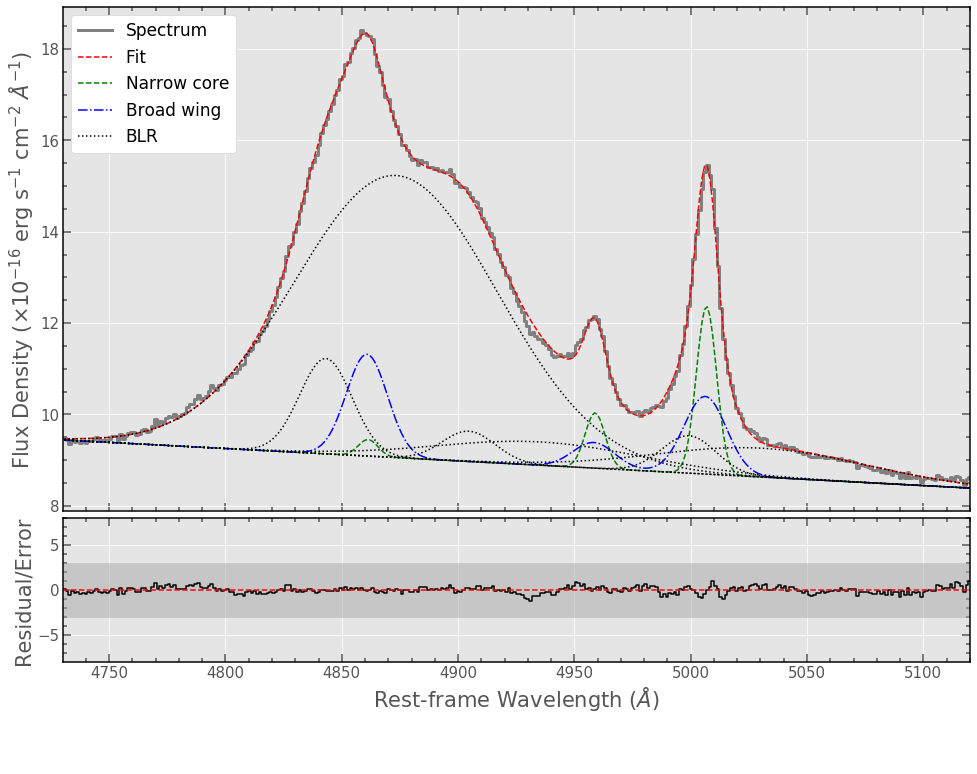

In [8]:
z = {"HE1029-1401":0.08582}

objs = z.keys()

broad2= {'HE1029-1401':True}


p_init= {'HE1029-1401':[ 3.62891615e-01,  3.67173165e+00,  2.56939168e+04,  2.71861223e+02,
  2.22874877e+00,  1.69939079e+00,  2.56590785e+04,  5.86117577e+02,
  6.17512922e+00,  6.30901885e-01,  2.64972720e+04,  2.88554390e+03,
  2.08744957e+00,  8.18706853e-01,  2.44768881e+04,  7.48665795e+02,
 -2.48774779e+00,  2.22161064e+01]}


for obj in objs:
     algorithm_script(obj,p_init[obj],z[obj],broad2[obj]) 


# 